## Exoplanets homework \#2

Starting with orbital code from homework \#1:

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u
import astropy.constants as consts
from astropy.modeling import models, fitting
from scipy.optimize import curve_fit

In [ ]:
G = consts.G  # gravitational constant
M = consts.M_sun  # using M_sun for M_star
a = 1 * u.AU  # semimajor axis (Earth value)
#e = 0.01671  # orbital eccentricity (Earth value)
e = 63./365  # orbital eccentricity (birthday value)

# specific angular momentum (Ell = L/m)
def calc_Ell(a,e,M):
  return (G * M * a * (1 - e**2))**(1/2)
Ell = calc_Ell(a,e,M)

def dtheta(Ell, r, dt):
    return (Ell / (r**2)) * dt * u.rad

def r(a, e, theta):
    return (a * (1 - e**2)) / (1 + e * np.cos(theta))

def calc_period(a, M):
    return ((4 * np.pi**2 * a**3)/(G * M))**0.5

365.25689838404185 d


In [ ]:
t0 = 0. * u.day
tf = calc_period(a, M).to(u.day)
times = np.linspace(t0, tf, 1000)
dt = times[1] - times[0]
theta = 0. * u.rad
r1 = a * (1 - e)  # r0 at periastron
r_vals = []
x_vals=[]
y_vals=[]
theta_vals = []

e = 63./365  # eccentricity
Ell = calc_Ell(a,e,M)  # specific angular momentum

plt.rcParams["figure.figsize"] = [7.50, 7.50]
fig = plt.figure()
ax = fig.add_subplot(111,aspect='equal')

for i in times:
    r_vals.append(r1)
    theta_vals.append(theta)
    x_vals.append(r1 * np.cos(theta))
    y_vals.append(r1 * np.sin(theta))
    theta = theta + dtheta(Ell, r1, dt)  # new theta
    r1 = r(a, e, theta)  # new radius
    
plt.scatter(x_vals*u.AU, y_vals*u.AU, color='blue', s=20)
plt.scatter(0, 0, color='red', marker='*', s=200)
plt.show()

## Question 1a:

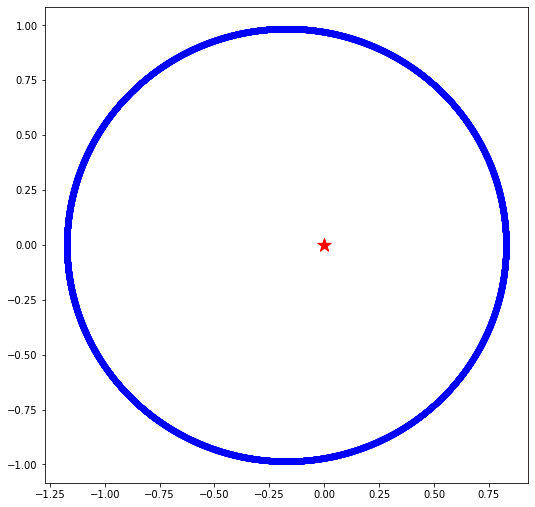

In [ ]:
def livin_la_vis_viva_loca(M, r, a):
  return np.sqrt(consts.G*M*(2./r - 1./a))

# redo with
t0 = 0. * u.day
tf = calc_period(a, M).to(u.day)
times = np.linspace(t0, tf, 20000)
dt = times[1] - times[0]
theta = 0. * u.rad
r1 = a * (1 - e)  # r0 at periastron
r_vals = []
x_vals=[]
y_vals=[]
theta_vals = []
v_vals=[]

e = 63./365  # eccentricity
Ell = calc_Ell(a,e,M)  # specific angular momentum

plt.rcParams["figure.figsize"] = [7.50, 7.50]
fig = plt.figure()
ax = fig.add_subplot(111,aspect='equal')

for i in times:
    r_vals.append(r1)
    theta_vals.append(theta)
    x_vals.append(r1 * np.cos(theta))
    y_vals.append(r1 * np.sin(theta))
    v_vals.append(livin_la_vis_viva_loca(M, r1, a))
    theta = theta + dtheta(Ell, r1, dt)  # update theta
    r1 = r(a, e, theta)  # update radius
    
plt.scatter(x_vals*u.AU, y_vals*u.AU, color='blue', s=20)
plt.scatter(0, 0, color='red', marker='*', s=200)
plt.show()

In [ ]:
R = consts.R_sun
D = 2 * R / v_vals[0]  # transit duration
print(D.to(u.hr))

10.900288038003552 h


In [ ]:
print(v_vals[0].decompose())  # this should be around 30 km/s to be sensible (Earth-like)
                              # ...maybe a bit more since this is at periastron and the eccentricity is greater

35457.7786066275 m / s


Using the vis-viva equation, we get an orbital velocity of the planet at periastron of $\sim 35 \, \mathrm{km/s}$. We can approximate the transit duration as the time it takes to traverse $2 R_{\star}$ (the entire face of the star) at the given orbital velocity and find a duration of $\sim 10.9 \, \mathrm{hours}$.

## Question 1b:

In [ ]:
stop_scan = (np.abs(y_vals*u.AU) > R).argmax()  # first index where y_val > R
print(stop_scan-1)  # how many points?
Db = (times[stop_scan-1] - min(times))*2  # multiplying by 2 because it's only half the duration... this is kinda quick and dirty sorry
print(Db.to(u.hr))

12
10.51992466969389 h


In [ ]:
print((10.5 - 10.9) / 10.9 * 100.0)

-3.6697247706422047


The transit duration calculated as the time between where the absolute value of $r_y$ exceeds $R_{\star}$ (for $x \gt 0$) gives a transit duration of $\sim 10.5 \, \mathrm{hours}$, about 4\% less than the duration estimate we obtained using the method of 1a.

## Question 1c:

Now we use equation 14 from Seager's $\textit{Exoplanets}$, section "Transits and Occultations":

$T = \frac{P}{\pi} \arcsin \bigg[ \frac{R_{\star} \sqrt{(1+k)^2 - b^2}}{a \sin i} \bigg]$

modified for eccentric orbits by the dimensionless factor from equation 16, $\frac{\sqrt{1-e^2}}{1 + e \sin \omega}$; and assuming an impact parameter $b = 0$, $k = R_p / R_{\star}$, orbital inclination $i = \pi / 2$, and $\omega = \pi / 2$.

In [ ]:
def transit_duration(P, R, Rp, b, a, inc, e, omega): 
    expression = (R * np.sqrt((1 + (Rp/R))**2 - b**2)) / (a * np.sin(inc))
    e_factor = np.sqrt(1 - e**2)/(1 + e * np.sin(omega))
    return (P / np.pi) * np.arcsin(expression) * e_factor

b = 0
inc = np.pi/2 * u.rad
omega = np.pi/2 * u.rad
Rp = consts.R_earth

Dc = transit_duration(tf, R, Rp, b, a, inc, e, omega)
print((Dc/u.rad).to(u.h))  # idk how to sort out the units rn so I just divided by u.rad

Dc_circ = transit_duration(tf, R, Rp, b, a, inc, 0, omega)
print((Dc_circ/u.rad).to(u.h))  # idk how to sort out the units rn so I just divided by u.rad

11.000261043651602 h
13.095479480914893 h


The exact duration is 11 hours for this eccentric orbit, and 13 hours for a circular orbit. The eccentric orbit is about 2 hours faster (which makes sense, since the orbital velocity during transit would be greater for a more eccentric orbit).

## Question 1d:

In [ ]:
omega = 3 * np.pi / 2  # apoapse
Dd = transit_duration(tf, R, Rp, b, a, inc, e, omega)
print((Dd/u.rad).to(u.h))

15.589773929413528 h


In [ ]:
es = np.linspace(0, 1, 100)
for e in es:
    D_ecc = transit_duration(tf, R, Rp, b, a, inc, e, omega)/u.rad
    D_circ = transit_duration(tf, R, Rp, b, a, inc, 0, omega)/u.rad
    ratio = D_ecc/D_circ
    if ratio >= 1.1:
        print(e, D_ecc.to(u.h), D_circ.to(u.h), ratio)
        break

0.10101010101010102 14.492377899434619 h 13.095479480914893 h 1.1066702766061784


The transit duration with apoapse pointed towards the viewer would be $\sim 15.5 \, \mathrm{hours}$. If we can measure the transit duration to a precision of 10\%, then in order to distinguish a circular orbit from an accentric one, the eccentric transit duration must differ from the circular one by at least 10\%. The eccentricity must be $e \ge 0.10$ for us to make this distinction with apoapse pointed towards the viewer.

## Question 2a:

We derived in class that the probability of overlap of multiple objects is $P \approx n D \sigma$, where $n$ is the number density of objects, $D$ is the distance to the galactic center, and $\sigma$ is the cross-section of interaction.

In [ ]:
P = (5 / u.pc**3) * (100 * u.lyr) * (np.pi * (10 * u.AU)**2)
print('probability =',P.decompose())

probability = 1.1319929848584845e-06


The probability is $P \approx 10^{-6}$.

## Question 2b:

The Einstein radius is given by:

$\theta_E = \bigg[ \frac{4GM}{c^2} \bigg( \frac{1}{D_L} - \frac{1}{D_S} \bigg) \bigg]$

where $D_L$ is the distance to the anterior lensing star and $D_S$ is the distance to the posterior source star. We will assume that the lensing star is Solar type.

In [ ]:
theta_E = np.sqrt((4 * consts.G * consts.M_sun / consts.c**2) * (1/(10 * u.lyr) - 1/(100 * u.lyr))).decompose()*u.rad.to(u.arcsec)
print(theta_E)

0.048893278851550835


To detect planets, they must occur right on top of the Einstein ring. 

The Einstein ring radius is $0.05''$.

In [ ]:
print((10 * u.lyr.to(u.pc) * theta_E))
print((50 * u.lyr.to(u.pc) * theta_E))

0.1499074744263107
0.7495373721315535


For stars 10 and 50 lightyears away, an Einstein ring radius of $0.05''$ corresponds to distances from the star of 0.15 AU and 0.75 AU, respectively. This would be well within our own star's snow line, and even within that of an M dwarf which might have a snow line around 1 AU. Astronomers in the middle of a globular cluster would therefore not be able to use microlensing to find planets beyond the snow line as we do.

## Question 3a:

| star | detection | $p(D_{i}|f)$ |
| --- | --- | --- |
| 1 | 1 | $f$ |
| 2 | 1 | $f$ |
| 3 | 0 | $1-f$ |
| 4 | 0 | $1-f$ |

## Question 3b:

$p(\{D\}|f) = f^2 (1-f)^2$

## Question 3c:

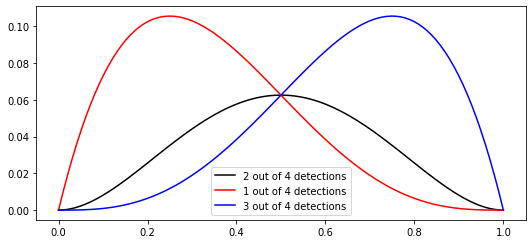

In [ ]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

x = np.linspace(0, 1, 100)

### for 2 out of 4 detections
def f1(x):
   return x**2 * (1-x)**2

### for 1 out of 4 detections
def f2(x):
   return x * (1-x)**3

### for 3 out of 4 detections
def f3(x):
   return x**3 * (1-x)

plt.plot(x, f1(x), color='black', label='2 out of 4 detections')
plt.plot(x, f2(x), color='red', label='1 out of 4 detections')
plt.plot(x, f3(x), color='blue', label='3 out of 4 detections')
plt.legend()
plt.show()

The likelihood goes to zero for $f = 0$ and $f = 1$. Maximum likelihood occurs at $f = 0.5$ for the original case (2 out of 4 detections).

## Question 3d:

In [ ]:
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, f1(x))
print(g)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude     mean        stddev      
    ----------------- ---- -------------------
    0.064906763350347  0.5 0.21185317354820687


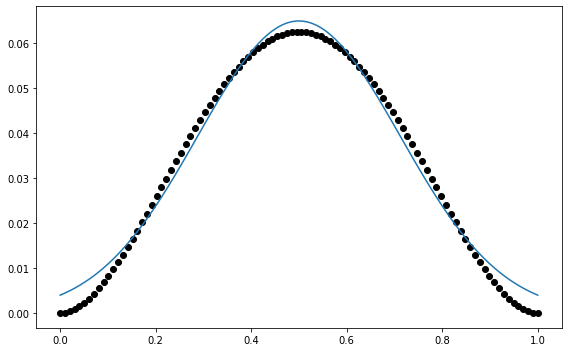

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(x, f1(x), 'ko')
plt.plot(x, g(x), label='Gaussian')

In [ ]:
# documentation: Standard deviation of the Gaussian with FWHM = 2 * stddev * np.sqrt(2 * np.log(2)).

# FWHM=sigma*sqrt(8 ln 2)

fwhm=2*g.stddev[0]
print(fwhm)

0.42370668312080656


In [ ]:
# using curve_fit instead
def gauss(x, a, mu, sigma):
    return a*np.exp(-0.5*(x-mu)**2/(sigma**2))
popt, pcov = curve_fit(gauss, x, f1(x), p0=[0.06,0.5,0.25]) # p0 = best guess
fit = gauss(x, *popt)
print('mu =', popt[1],'\nsigma =', popt[2])

mu = 0.49999999999854816 
sigma = 0.21185334136875036


Our confidence interval $\bar{f} \pm \sigma$ is $0.5 \pm 0.2$.

## Question 3e:

"2 to 1 odds" is equivalent to 66\% odds, but here we have 68\% odds ($1\sigma$) that "50\% of stars have planets," so we should call our friend at the Times.